# Feature Engineering
  

In [1]:
# Imports  for data manipulation 
import pandas as pd
import numpy as np

# Imports for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Import pydataset for dataset loading
from pydataset import data

# Import MinMaxScaler for preprocessing
from sklearn.preprocessing import MinMaxScaler

# Import feature selection tools
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Import Linear Regression for modeling
from sklearn.linear_model import LinearRegression

# My imports 
import wrangle
import prepare

#import warnings
import warnings
warnings.filterwarnings("ignore")



 ## 1.0 Load the tips dataset

In [2]:
#load the data from pydataset 

df = data('tips')
df.head(3)


,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 1 to 244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


In [4]:
# check for nulls
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

## 1. a. Create a column named price_per_person. This should be the total bill divided by the party size.

In [3]:
# Create a column named price_per_person
df['price_per_person'] = df['total_bill'] / df['size']
df.head(3)

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333


In [6]:
df.head(3)

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333


## 1. b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

#### GOAL: Predicting the tip amount.

#### Features like total_bill, size (party size), and  time (lunch/dinner) might be important for predicting the tip amount.

In [7]:
# Create a function that groups our data by datatype
def discrete_cols(df):
    cat_cols= df.select_dtypes(include=['object']).columns.tolist()
    return cat_cols

def continuous_cols(df):
    con_cols= df.select_dtypes(exclude=['object']).columns.tolist()
    return con_cols


In [8]:
# use the function on the tips dataframe to separate our continuous variables
con_cols = continuous_cols(df)
con_cols


['total_bill', 'tip', 'size', 'price_per_person']

In [9]:
# use the function on the tips dataframe to separate our discrete or categorical variables
cat_cols = discrete_cols(df)
cat_cols

['sex', 'smoker', 'day', 'time']

#### Methods to find the most important features to predict tip amount:

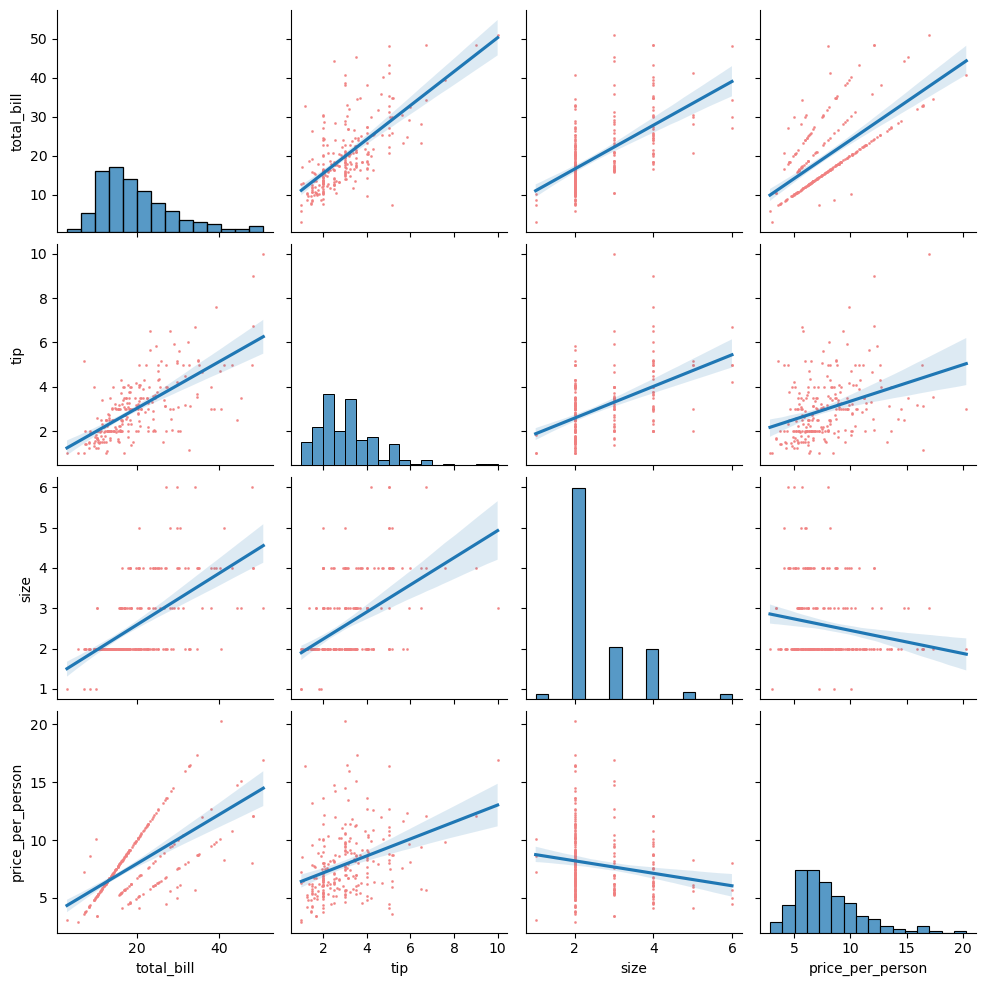

In [15]:
# pairplot to visualize correlation
sns.pairplot(data=df, kind = 'reg', plot_kws={'scatter_kws': {'s': 1, 'color': 'lightcoral'}})
plt.show()

It appears that "tip" and "total_bill" seem to have some correlation.


In [18]:
# take a look at correlation
df[con_cols].corr()


,total_bill,tip,size,price_per_person
total_bill,1.000000,0.675734,0.598315,0.647497
tip,0.675734,1.000000,0.489299,0.347393
size,0.598315,0.489299,1.000000,-0.175412
price_per_person,0.647497,0.347393,-0.175412,1.000000


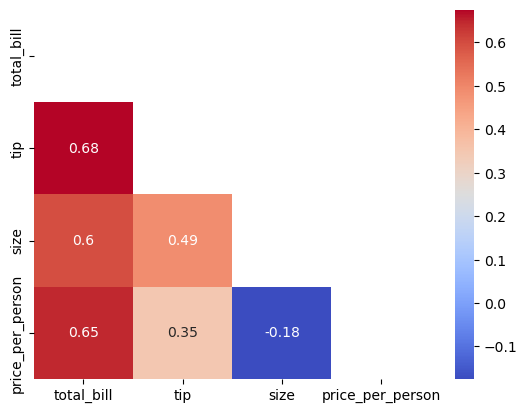

In [19]:
# plot heatmap
sns.heatmap(df[con_cols].corr(), cmap='coolwarm', annot=True,
           mask=np.triu(df[con_cols].corr()))
plt.show()


> "total_bill" has the highest correlation with "tip"

Before using Select K Best to select the top 2 features for predicting tip amount you must have encocded object types and scaled numerical types (excluding the target) 

Note:
We need to create dummy variables for two reasons:
In order to use RFE, we cannot have 'object' datatypes

- We will also need dummy variables in order to scale. The scaler does not know what objects are. It doesn't understand what "Female" or "Saturday" mean.

In [4]:
#use the function we created to split our data
train, validate, test = wrangle.split_data(df)

train: 146 (60.0% of 244)
validate: 49 (20.0% of 244)
test: 49 (20.0% of 244)


#### NOTE: Here is a demonstration of separating X variables from the y variable and using a scaler (only scaling numerical columns)

In [6]:
# X and y splits to scale
target = "tip"

X_train = train[['total_bill', 'size', 'price_per_person']]
y_train = train[target]

X_validate = validate[['total_bill', 'size', 'price_per_person']]
y_validate = validate[target]

X_test = test[['total_bill', 'size', 'price_per_person']]
y_test = test[target]


In [8]:
#assign to variable #need scaler for each independent variable
#create it
scaler = MinMaxScaler()

In [9]:
#fit it
scaler.fit(X_train)

MinMaxScaler()

In [10]:
#use it
#make a new column within train
#use 'transform' instead of 'predict'
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

### Create Dummies

NOTE: This is just a short section to demonstrate how you would encode cat columns, scale num columns, and separate X variables from y viariables for a train data set. 

This demonstration assumes you want to use "size" as categorical, but it's up to you what you want to do with it. If you want it to be continuous then add it to the list of columns to scale.


In [9]:
#Create dummy columns of my categorical features
train_dummy = pd.get_dummies(data=train, columns=['sex', 'smoker', 'day', 'time', 'size'], drop_first=True) 
train_dummy.head(3)

,total_bill,tip,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch,size_2,size_3,size_4,size_5,size_6
37,16.31,2.00,5.436667,True,False,True,False,False,False,False,True,False,False,False
218,11.59,1.50,5.795000,True,True,True,False,False,False,True,False,False,False,False
64,18.29,3.76,4.572500,True,True,True,False,False,False,False,False,True,False,False


In [10]:
#Instantiate the min-max scaler and fit/transform my continuous features
mms_dummy = MinMaxScaler()

#fit
mms_dummy.fit(train_dummy[['total_bill', 'price_per_person']])

#transform
train_dummy[['total_bill', 'price_per_person']] = mms_dummy.transform(train_dummy[['total_bill', 'price_per_person']])

In [12]:
train_dummy.head(3)


,total_bill,tip,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch,size_2,size_3,size_4,size_5,size_6
37,0.292920,2.00,0.177401,True,False,True,False,False,False,False,True,False,False,False
218,0.188496,1.50,0.202216,True,True,True,False,False,False,True,False,False,False,False
64,0.336726,3.76,0.117555,True,True,True,False,False,False,False,False,True,False,False


In [13]:
#Create X and y dataframes
X_train_dummy = train_dummy.drop(columns=['tip'])
y_train_dummy = train_dummy['tip']

## 1.c. Use Select K Best to select the top 2 features for predicting tip amount. What are they?

SelectKBest requires you to call the number of "k" or features that you want

- For this instance, our parameters are: f_regression stats test, give me 2 features
- f_regression stats test: scores relationships between target and the other variables

In [11]:
#create
kbest = SelectKBest(score_func=f_regression, k=2)


In [12]:
#fit
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x148c74540>)

In [13]:
#create the mask
feature_mask = kbest.get_support()


In [14]:
#now we are going to ask for the column names of select k best top 2 features
X_train.columns[feature_mask]


Index(['total_bill', 'size'], dtype='object')

In [15]:
# We can also complete the masking and creating feature column list in one step once we get comfortable

X_train.columns[kbest.get_support()]


Index(['total_bill', 'size'], dtype='object')

In [ ]:
# OR

In [24]:
# Let's break our data into X and y subsets
X = df[['total_bill', 'size','price_per_person']]  # Features
y = df['tip']  # Target variable

In [25]:
# Initialize SelectKBest with k=2
selector = SelectKBest(k=2)

In [26]:
# Fit and transform the data
X_new = selector.fit_transform(X, y)

In [27]:
# Get the names of the top 2 selected features
selected_features_kbest = X.columns[selector.get_support(indices=True)]

In [ ]:
selected_features_kbest

In [29]:
# Print the results
print("Top 2 features by SelectKBest:", selected_features_kbest)

Top 2 features by SelectKBest: Index(['total_bill', 'size'], dtype='object')


## 1. d. Use Recursive Feature Elimination to select the top 2 features for tip amount. What are they?

In [32]:
# Use Recursive Feature Elimination (RFE) to select the top 2 
# features for tip amount
# Initialize RFE with a linear regression estimator and
# n_features_to_select=2
estimator = LinearRegression()
rfe_selector = RFE(estimator, n_features_to_select=2)


In [42]:
# Fit and transform the data
X_rfe = rfe_selector.fit(X_train_scaled, y_train)

In [43]:
# Get the names of the top 2 selected features by RFE
selected_features_rfe = X_train.columns[rfe_selector.support_].tolist()


In [44]:
selected_features_rfe

['total_bill', 'size']

In [45]:
# Print the results
print("Top 2 features by RFE:", selected_features_rfe)

Top 2 features by RFE: ['total_bill', 'size']


## 2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [7]:
# create functions for SelectKBest and RFE:
from sklearn.feature_selection import SelectKBest, RFE

# Function to select top k features using SelectKBest
# NOTE how the object is fit with non scaled data.
def select_kbest(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit(X, y)
    selected_features = X.columns[X_new.get_support(indices=True)]
    return selected_features


In [51]:
# Test the functions with the tips dataset
select_kbest(X_train, y_train, 2)


Index(['total_bill', 'size'], dtype='object')

## 3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top n features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [8]:
# Function to select top k features using RFE
# NOTE how the object is fit with non scaled data.
def rfe(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the recursive feature elimination process
    '''
    rf = RFE(LinearRegression(), n_features_to_select=k)
    rf.fit(X, y)
    mask = rf.get_support()
    return X.columns[mask]


In [62]:
#let's call our function using x and y train with the 2 top features

rfe(X_train, y_train, 2)


Index(['size', 'price_per_person'], dtype='object')

## 4. Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both Select K Best and Recursive Feature Elimination (use the functions you just built to help you out).

In [2]:
# Load the Swiss dataset
df = data('swiss')
df.head(3)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [4]:
df.columns

Index(['Fertility', 'Agriculture', 'Examination', 'Education', 'Catholic',
       'Infant.Mortality'],
      dtype='object')

In [10]:
# Initialize the MinMaxScaler
mms = MinMaxScaler()

# Select the columns you want to scale
to_scale = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

# Scale the selected columns and replace them in the original DataFrame
df[to_scale] = mms.fit_transform(df[to_scale])

# Display the first 3 rows of the modified DataFrame
df.head(3)
# first initialize the MinMaxScaler and then scale the selected columns directly in the DataFrame df. 
# This should resolve the "ValueError" issue, and the scaling will be correctly applied to the specified columns.



,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,0.178531,0.352941,0.211538,0.079816,0.721519
Delemont,83.1,0.496045,0.088235,0.153846,0.845069,0.721519
Franches-Mnt,92.5,0.435028,0.058824,0.076923,0.932550,0.594937


In [9]:

# Use SelectKBest to select the top 3 features for predicting Fertility
X_swiss = df.drop(columns=['Fertility'])  # Exclude the target variable
y_swiss = df['Fertility']  # Target variable

selected_features_kbest_swiss = select_kbest(X_swiss, y_swiss, 3)


# Use RFE to select the top 3 features for predicting Fertility
selected_features_rfe_swiss = rfe(X_swiss, y_swiss, 3)

print("Top 3 features by SelectKBest (Swiss dataset):", selected_features_kbest_swiss, "\n")
print("Top 3 features by RFE (Swiss dataset):", selected_features_rfe_swiss)


Top 3 features by SelectKBest (Swiss dataset): Index(['Examination', 'Education', 'Catholic'], dtype='object') 

Top 3 features by RFE (Swiss dataset): Index(['Agriculture', 'Education', 'Infant.Mortality'], dtype='object')


# Functionize a couple of tasks:

In [7]:
#create a function to isolate the target variable AND split a DF
def X_y_split(df, target):
    '''
    This function takes in a dataframe and a target variable
    Then it returns the X_train, y_train, X_validate, y_validate, X_test, y_test
    and a print statement with the shape of the new dataframes
    '''  
    train, validate, test = split_data(df)

    X_train = train.drop(columns= target)
    y_train = train[target]

    X_validate = validate.drop(columns= target)
    y_validate = validate[target]

    X_test = test.drop(columns= target)
    y_test = test[target]
        
    # Have function print datasets shape
    print(f'X_train -> {X_train.shape}')
    print(f'X_validate -> {X_validate.shape}')
    print(f'X_test -> {X_test.shape}')  
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test


In [5]:
# Create a function to isolate the target variable from an ALREADY split dataframe
def X_y_split(train, validate, test, target):
    '''
    This function takes in train, validate, and test dataframes and the target variable.
    Then it returns the X_train, y_train, X_validate, y_validate, X_test, y_test.
    '''  

    X_train = train.drop(columns= target)
    y_train = train[target]

    X_validate = validate.drop(columns= target)
    y_validate = validate[target]

    X_test = test.drop(columns= target)
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test


In [6]:
# use the function on zillow for example
# X_train, y_train, X_validate, y_validate, X_test, y_test = X_y_split(train, validate, test, 'property_value')
